In [1]:
import sys

sys.path.append("..")

In [2]:
from tensorflow import keras

In [3]:
from utils.preprocessing_utils import PreprocessingUtils

In [4]:
from utils.model_wrapper import ModelWrapper

In [5]:
preprocessing_utils = PreprocessingUtils()

Files already exist, skipping...
Loading images and labels...
Images and labels loaded successfully!
Preprocessing labels...
Labels preprocessed successfully!
Splitting data into train, test and validation sets...
Data split successfully!


In [6]:
def inception_module(x, filters: list[int]):
    tower_1 = keras.layers.Conv2D(filters[0], (1, 1), padding="same", activation="relu")(x)
    tower_1 = keras.layers.Conv2D(filters[1], (3, 3), padding="same", activation="relu")(tower_1)

    tower_2 = keras.layers.Conv2D(filters[2], (1, 1), padding="same", activation="relu")(x)
    tower_2 = keras.layers.Conv2D(filters[3], (5, 5), padding="same", activation="relu")(tower_2)

    tower_3 = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
    tower_3 = keras.layers.Conv2D(filters[4], (1, 1), padding="same", activation="relu")(tower_3)

    tower_4 = keras.layers.Conv2D(filters[5], (1, 1), padding="same", activation="relu")(x)

    concatenated = keras.layers.Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
    return concatenated


def build_google_net(model_name: str):
    input_layer = keras.layers.Input(shape=preprocessing_utils.images.shape[1:])

    x = keras.layers.Conv2D(
        64, (7, 7), strides=(2, 2), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(input_layer)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Conv2D(
        64, (1, 1), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(x)
    x = keras.layers.Conv2D(
        192, (3, 3), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = inception_module(x, [64, 128, 32, 32, 32, 32])
    x = inception_module(x, [128, 192, 96, 64, 64, 64])

    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.5)(x)

    output_layer = keras.layers.Dense(preprocessing_utils.num_classes, activation="softmax")(x)

    model = keras.models.Model(name=model_name, inputs=input_layer, outputs=output_layer)

    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.summary()

    return model

In [7]:
google_net_wrapper = ModelWrapper("GoogleNet", preprocessing_utils=preprocessing_utils)

In [8]:
google_net_wrapper.build_model(build_fn=build_google_net, model_name=google_net_wrapper.model_name)

Building model...
Model: "GoogleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                        

In [9]:
google_net_wrapper.train_evaluate_and_save_model(
    batch_size=32,
    callbacks=[keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)],  # type: ignore
)

Epoch 1/100
129/129 [==============================] - ETA: 0s - loss: 3.8458 - accuracy: 0.0671
Epoch 1: val_loss improved from inf to 3.78175, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 7s 37ms/step - loss: 3.8458 - accuracy: 0.0671 - val_loss: 3.7817 - val_accuracy: 0.0599 - lr: 0.0100
Epoch 2/100
127/129 [============================>.] - ETA: 0s - loss: 3.7974 - accuracy: 0.0719
Epoch 2: val_loss improved from 3.78175 to 3.75203, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 32ms/step - loss: 3.7968 - accuracy: 0.0720 - val_loss: 3.7520 - val_accuracy: 0.0599 - lr: 0.0100
Epoch 3/100
127/129 [============================>.] - ETA: 0s - loss: 3.7284 - accuracy: 0.0933
Epoch 3: val_loss improved from 3.75203 to 3.62550, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 31ms/step - loss: 3.7275 - accuracy: 0.0939 - val_loss: 3.6255 - val_accuracy: 0.1198 - lr: 0.0100
Epoch 4/100
127/129 [============================>.] - ETA: 0s - loss: 3.5655 - accuracy: 0.1403
Epoch 4: val_loss improved from 3.62550 to 3.41735, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 32ms/step - loss: 3.5639 - accuracy: 0.1408 - val_loss: 3.4173 - val_accuracy: 0.1567 - lr: 0.0100
Epoch 5/100
127/129 [============================>.] - ETA: 0s - loss: 3.3757 - accuracy: 0.1781
Epoch 5: val_loss improved from 3.41735 to 3.25742, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 32ms/step - loss: 3.3749 - accuracy: 0.1783 - val_loss: 3.2574 - val_accuracy: 0.1797 - lr: 0.0100
Epoch 6/100
127/129 [============================>.] - ETA: 0s - loss: 3.2368 - accuracy: 0.2060
Epoch 6: val_loss improved from 3.25742 to 3.08170, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 31ms/step - loss: 3.2355 - accuracy: 0.2068 - val_loss: 3.0817 - val_accuracy: 0.2166 - lr: 0.0100
Epoch 7/100
127/129 [============================>.] - ETA: 0s - loss: 3.0699 - accuracy: 0.2434
Epoch 7: val_loss improved from 3.08170 to 3.01242, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 31ms/step - loss: 3.0693 - accuracy: 0.2435 - val_loss: 3.0124 - val_accuracy: 0.2627 - lr: 0.0100
Epoch 8/100
127/129 [============================>.] - ETA: 0s - loss: 2.9366 - accuracy: 0.2795
Epoch 8: val_loss improved from 3.01242 to 2.85699, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 31ms/step - loss: 2.9378 - accuracy: 0.2797 - val_loss: 2.8570 - val_accuracy: 0.3088 - lr: 0.0100
Epoch 9/100
127/129 [============================>.] - ETA: 0s - loss: 2.7814 - accuracy: 0.3255
Epoch 9: val_loss did not improve from 2.85699
129/129 [==============================] - 3s 21ms/step - loss: 2.7837 - accuracy: 0.3245 - val_loss: 2.8633 - val_accuracy: 0.3318 - lr: 0.0100
Epoch 10/100
127/129 [============================>.] - ETA: 0s - loss: 2.6167 - accuracy: 0.3671
Epoch 10: val_loss improved from 2.85699 to 2.80957, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 31ms/step - loss: 2.6170 - accuracy: 0.3671 - val_loss: 2.8096 - val_accuracy: 0.3180 - lr: 0.0100
Epoch 11/100
127/129 [============================>.] - ETA: 0s - loss: 2.4372 - accuracy: 0.4136
Epoch 11: val_loss improved from 2.80957 to 2.75364, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 31ms/step - loss: 2.4336 - accuracy: 0.4147 - val_loss: 2.7536 - val_accuracy: 0.3733 - lr: 0.0100
Epoch 12/100
127/129 [============================>.] - ETA: 0s - loss: 2.2730 - accuracy: 0.4683
Epoch 12: val_loss did not improve from 2.75364
129/129 [==============================] - 3s 20ms/step - loss: 2.2778 - accuracy: 0.4658 - val_loss: 2.8383 - val_accuracy: 0.3272 - lr: 0.0100
Epoch 13/100
127/129 [============================>.] - ETA: 0s - loss: 2.1095 - accuracy: 0.5180
Epoch 13: val_loss did not improve from 2.75364
129/129 [==============================] - 3s 21ms/step - loss: 2.1060 - accuracy: 0.5193 - val_loss: 2.8568 - val_accuracy: 0.3502 - lr: 0.0100
Epoch 14/100
127/129 [============================>.] - ETA: 0s - loss: 1.9412 - accuracy: 0.5795
Epoch 14: val_loss did not improve from 2.75364
129/129 [==============================] - 3s 21ms/step - loss: 1.9415 - accuracy: 0.5794 - val_loss: 2.8517 - val_accuracy: 0.

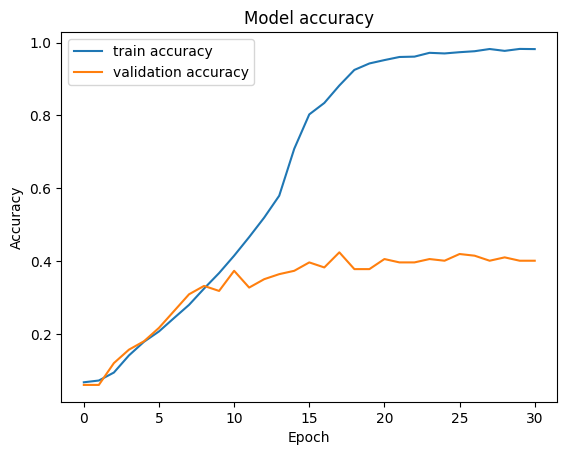

In [10]:
google_net_wrapper.plot_accuracy()

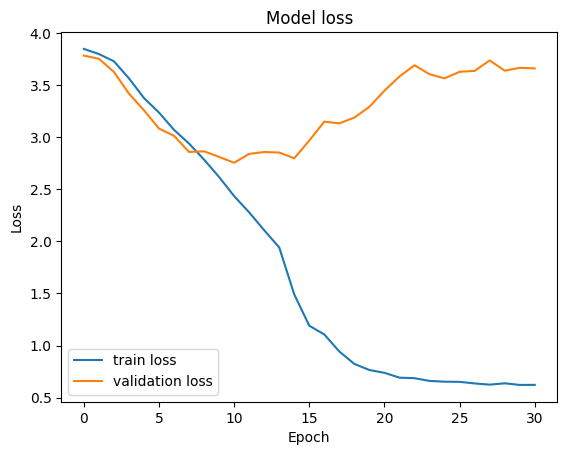

In [11]:
google_net_wrapper.plot_loss()

20/20 [==============================] - 0s 8ms/step


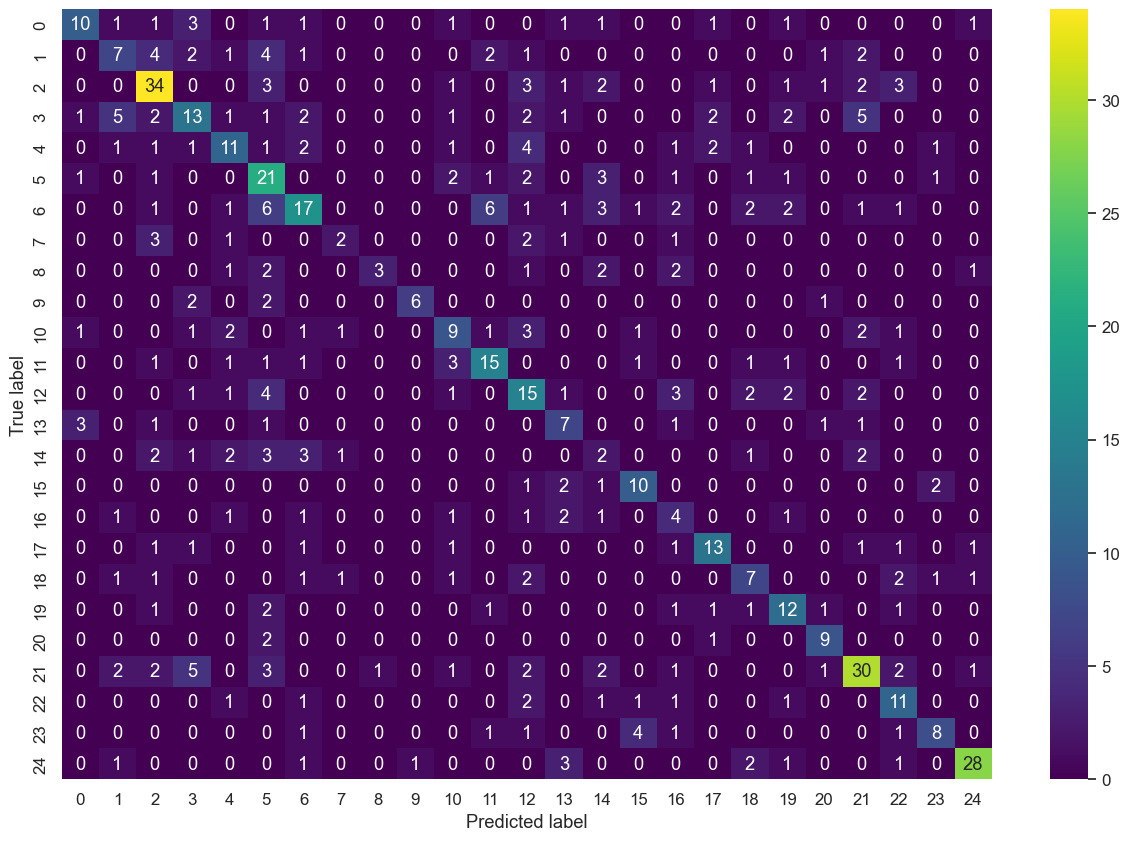

In [12]:
google_net_wrapper.display_confusion_matrix()